## Searching for LSB objects in the third year of DES

In this notebook I summarize the efforts to find LSB objects in DES data and present some preliminary data.

In [1]:
# Import stuff
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
import skymapper as skm
from code.plot_utils import plot_pretty
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

%matplotlib inline
%pylab inline 
plot_pretty() 

Populating the interactive namespace from numpy and matplotlib


### Part I: Machine learning for LSB  - false positives separation

In [2]:
from Train_set import supervised
y_dat, X_dat = supervised()

In [3]:
print(len(y_dat))

TP = y_dat[(y_dat==1)]
FP = y_dat[(y_dat==0)]

print(len(TP))
print(len(FP))

1262
302
960


So, my training set consists of 1262 object that I have visually classified; 302 were classified as genuine LSB objects, while 960 were spurious detections.

Let's split this sample into a training and test set and do the following:

Use SVMs, cross-validate to find the best hyperparameters and then evaluate the performance for the classifier.

Repeat for random forrestd and also use them to calculate the parameter importance.

In [4]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_dat, y_dat, train_size = 0.75, random_state = 42 )

//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### SVM Classifier

In [5]:
# Import the Support Vector Classifier
from sklearn.svm import SVC
svc = SVC(kernel='rbf')

In [6]:
from sklearn.grid_search import GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 50, 100, 150,200, 250, 300],
              'gamma': [0.0001, 0.0005, 0.0006, 0.0007, 0.0008,0.001, 0.003,0.005]}
grid = GridSearchCV(svc, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


CPU times: user 3.35 s, sys: 58.6 ms, total: 3.41 s
Wall time: 3.72 s
{'C': 200, 'gamma': 0.003}


In [7]:
svc_2 = SVC(C=200, kernel='rbf', gamma=0.003)
svc_2.fit(Xtrain, ytrain)
print(svc_2.score(Xtrain,ytrain))
print(svc_2.score(Xtest,ytest))

0.9027484143763214
0.8955696202531646


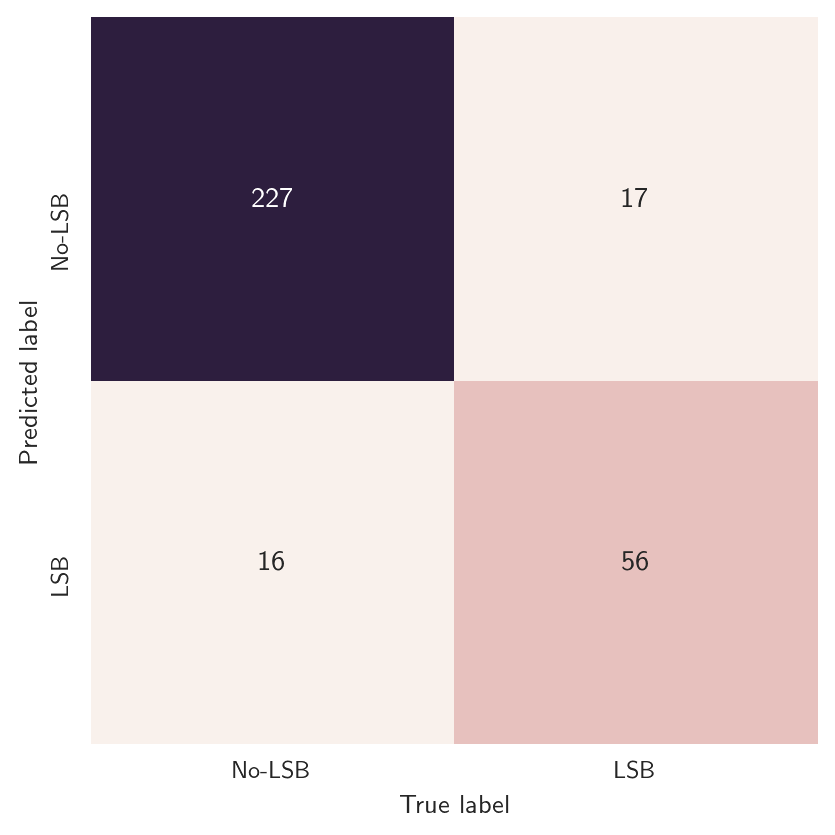

In [8]:
target_names = ['No-LSB', 'LSB']
y_fit = svc_2.predict(Xtest)
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_fit)
sns.heatmap(mat.T, square = True, annot=True, fmt='d', cbar=False, 
           xticklabels= target_names,
           yticklabels= target_names)

plt.xlabel('True label')
plt.ylabel('Predicted label');

The bad news are that out of the 76 objects predicted as LSB, 16 of them are false positives, that is $\sim 22 \%$ (However, such a small test sample results in high poisson noise).

In [9]:
# More metrics now
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
print(accuracy_score(ytest,y_fit))
print(precision_score(ytest,y_fit))
print(recall_score(ytest,y_fit))

0.8955696202531646
0.7777777777777778
0.7671232876712328


#### Random Forest classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(max_depth=11, n_estimators=20, max_features=5)

//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [11]:
param_grid = {'max_depth': [5,8,9,11,13,15],
              'n_estimators': [20,25,30,35,40,45,50],
             'max_features': [2,3,4,5,6,7,8,9]}
grid = GridSearchCV(RFC, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 2min 15s, sys: 1.44 s, total: 2min 16s
Wall time: 2min 26s
{'max_features': 6, 'n_estimators': 40, 'max_depth': 15}


Now Implement a random forest classifier with the best hyper-parameters

In [12]:
RFC_2 = RandomForestClassifier(max_depth=8, n_estimators=40, max_features=8)
RFC_2.fit(Xtrain, ytrain)
print(RFC_2.score(Xtrain,ytrain))
print(RFC_2.score(Xtest,ytest))

0.9841437632135307
0.8955696202531646


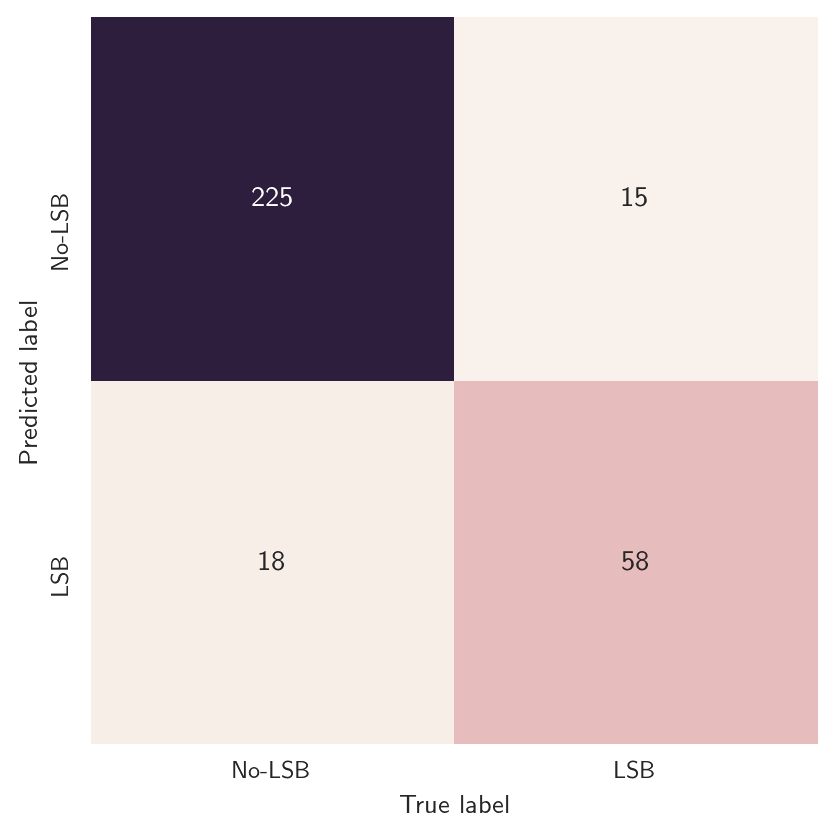

In [13]:
y_fit = RFC_2.predict(Xtest)

mat = confusion_matrix(ytest, y_fit)
sns.heatmap(mat.T, square = True, annot=True, fmt='d', cbar=False, 
           xticklabels= target_names,
           yticklabels= target_names)

plt.xlabel('True label')
plt.ylabel('Predicted label');

In [14]:
# More metrics now
print(accuracy_score(ytest,y_fit))
print(precision_score(ytest,y_fit))
print(recall_score(ytest,y_fit))

0.8955696202531646
0.7631578947368421
0.7945205479452054


Feature Importance

1. feature 9 (0.197777)
2. feature 0 (0.153996)
3. feature 10 (0.122236)
4. feature 4 (0.111801)
5. feature 1 (0.056665)
6. feature 3 (0.045244)
7. feature 5 (0.044515)
8. feature 11 (0.041963)
9. feature 13 (0.038820)
10. feature 14 (0.038679)
11. feature 15 (0.034282)
12. feature 12 (0.032298)
13. feature 2 (0.027919)
14. feature 8 (0.021791)
15. feature 7 (0.016793)
16. feature 6 (0.015220)


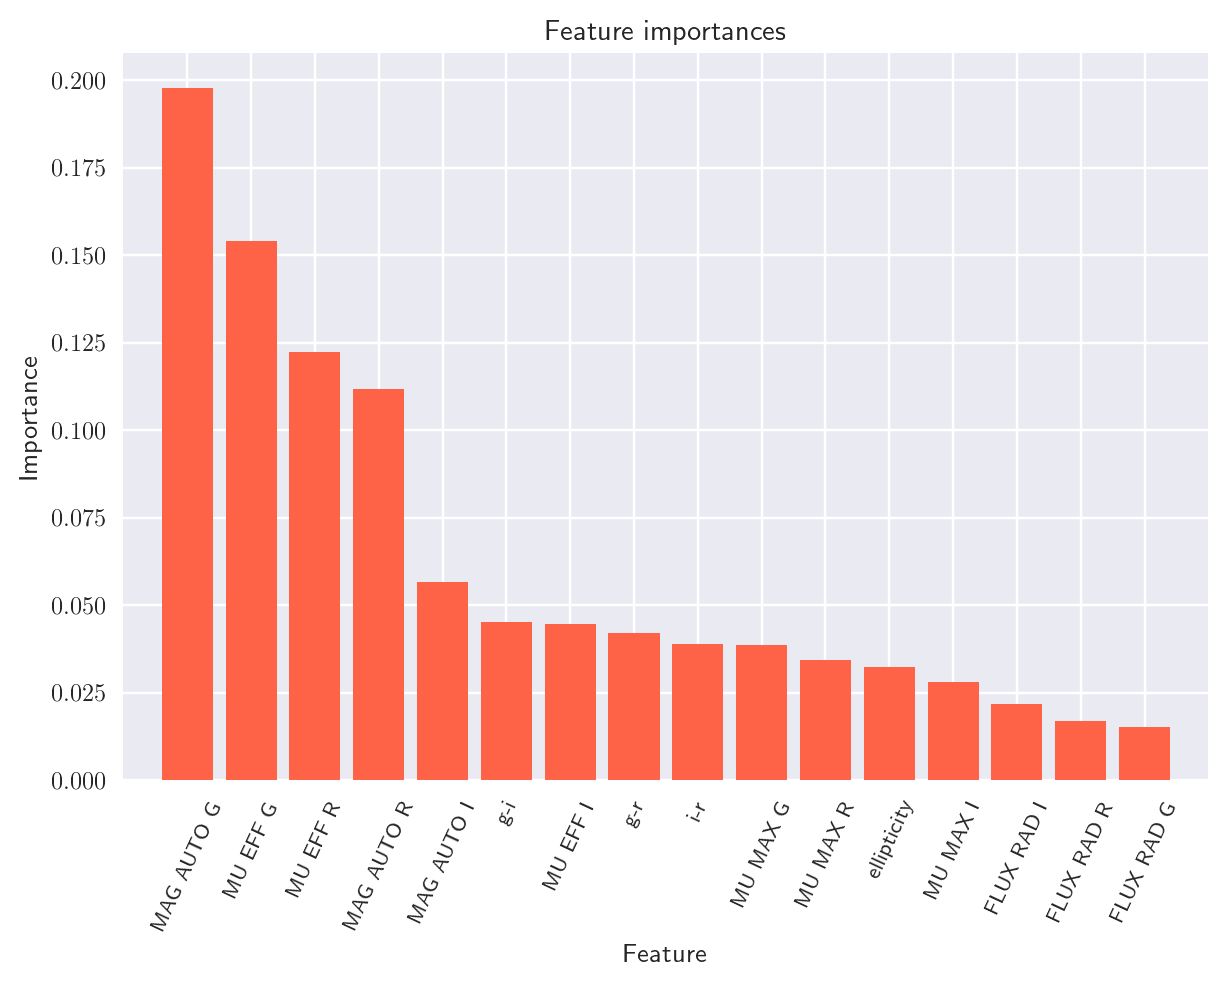

In [15]:
importances = RFC_2.feature_importances_
indices = np.argsort(importances)[::-1]

titles = ['MAG AUTO G', 'MU EFF G', 'MU EFF R', 'MAG AUTO R', 'MAG AUTO I', 'g-i', 'MU EFF I', 'g-r', 'i-r', 'MU MAX G', 'MU MAX R', 
         'ellipticity', 'MU MAX I', 'FLUX RAD I', 'FLUX RAD R', 'FLUX RAD G']

for f in range(Xtrain.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(Xtrain.shape[1]), importances[indices],
       color="tomato", align="center")
plt.xticks(range(Xtrain.shape[1]), titles, rotation=65, fontsize=9)
plt.xlim([-1, Xtrain.shape[1]])
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

I tested the SVM using the four most important features, but I realized that the accuracy is lower.

Let's plot the 2D distribution in the MAG_AUTO_G - MU_EFF_G space of the true LSB objects and of the spurious detections.  

In [16]:
# Define the arrays that contain the MAG_AUTO_G and MU_EFF_G
MAG_G = X_dat[:,0]
MU_EFF_G = X_dat[:,9]

MAG_G_T = MAG_G[(y_dat==1)]
MAG_G_F = MAG_G[(y_dat==0)]

MU_EFF_G_T = MU_EFF_G[(y_dat==1)]
MU_EFF_G_F = MU_EFF_G[(y_dat==0)]

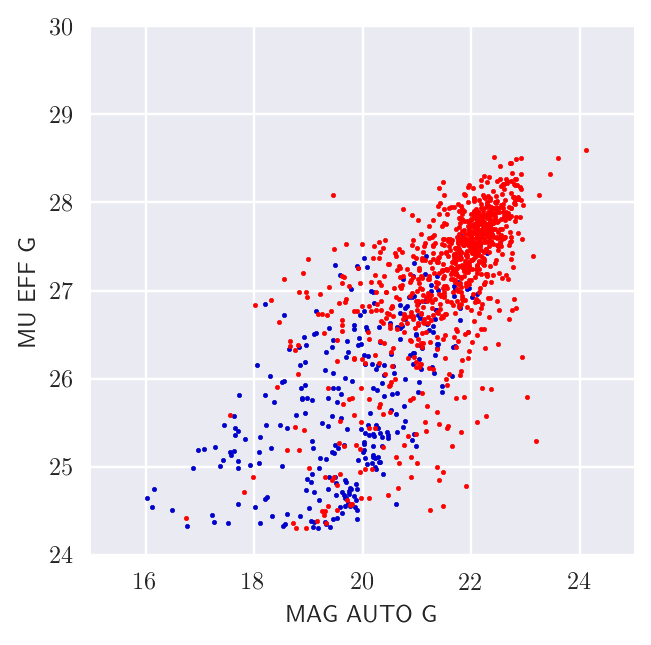

In [17]:
import seaborn as sns
sns.set()


plt.figure(figsize=(4.0,4.0))
plt.scatter(MAG_G_T,MU_EFF_G_T, color='mediumblue', s=3.0)
plt.scatter(MAG_G_F,MU_EFF_G_F, color='red', s=3.0)

plt.xlabel('MAG AUTO G', fontsize=10);plt.ylabel('MU EFF G', fontsize=10)
plt.xlim(15,25);plt.ylim(24,30)
plt.show()

Let's now make a similar plot, but with four categories, using the test set. The four categories will be:

- True positives 

- True negatives 

- False positives 

- False negatives

In [18]:
y_pred = svc_2.predict(Xtest)
y_true = ytest

MAG_G_TEST = Xtest[:,0]
MU_EFF_G_TEST = Xtest[:,9]


MAG_G_TP = MAG_G_TEST[(y_true==1)&(y_pred==1)]
MAG_G_TN = MAG_G_TEST[(y_true==0)&(y_pred==0)]
MAG_G_FP = MAG_G_TEST[(y_true==0)&(y_pred==1)]
MAG_G_FN = MAG_G_TEST[(y_true==1)&(y_pred==0)]

MU_EFF_G_TP = MU_EFF_G_TEST[(y_true==1)&(y_pred==1)]
MU_EFF_G_TN = MU_EFF_G_TEST[(y_true==0)&(y_pred==0)]
MU_EFF_G_FP = MU_EFF_G_TEST[(y_true==0)&(y_pred==1)]
MU_EFF_G_FN = MU_EFF_G_TEST[(y_true==1)&(y_pred==0)]

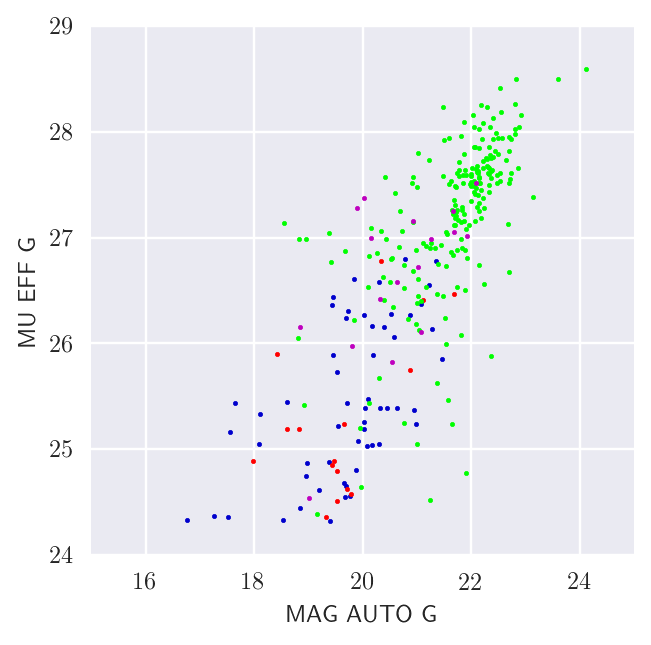

In [19]:
plt.figure(figsize=(4.0,4.0))
plt.scatter(MAG_G_TP,MU_EFF_G_TP, color='mediumblue', s=3.0)
plt.scatter(MAG_G_FP,MU_EFF_G_FP, color='red', s=3.0)
plt.scatter(MAG_G_TN,MU_EFF_G_TN, color='lime', s=3.0)
plt.scatter(MAG_G_FN,MU_EFF_G_FN, color='m', s=3.0)

plt.xlabel('MAG AUTO G', fontsize=10);plt.ylabel('MU EFF G', fontsize=10)
plt.xlim(15,25);plt.ylim(24,29)
plt.show()

We see that is not very easy to separate the true positives to the false positives by just checking the above plot.

## Classifying the objects in two $10^o \times 10^o$ regions 

Now we use the Support Vectro Machine classifier we trained above to classify the objects in two large regions of $10^o \times 10^o$:

- Region 1:
\begin{equation}
45 < RA < 55 \\
-35 < DEC < -25
\end{equation}

- Region 2:
\begin{equation}
20 < RA < 30\\
-55 < DEC < -45 
\end{equation}

In [20]:
from Region_1 import feat_return_1
from Region_2 import feat_return_2

In [21]:
X_feat_1, dnf_zmean_1, dnf_zmc_1, RA_1, DEC_1 = feat_return_1()
X_feat_2, dnf_zmean_2, dnf_zmc_2, RA_2, DEC_2 = feat_return_2()

#### Before classifying I perform the following cut in redshift. I consider only galaxies with mean redshift $0<z<0.2$
(the upper limit is a quite random choice, I should justify it later)

In [22]:
redshift_cut_1 = (dnf_zmean_1>0)&(dnf_zmean_1<0.2)&(dnf_zmc_1>0)
redshift_cut_2 = (dnf_zmean_2>0)&(dnf_zmean_2<0.2)&(dnf_zmc_2>0)

X_ft_1 = X_feat_1[redshift_cut_1]
X_ft_2 = X_feat_2[redshift_cut_2]
RA_1 = RA_1[redshift_cut_1]; DEC_1 = DEC_1[redshift_cut_1]
RA_2 = RA_2[redshift_cut_2]; DEC_2 = DEC_2[redshift_cut_2]

print(np.shape(X_ft_1))
print(np.shape(X_ft_2))

(1119, 16)
(742, 16)


Let's classify now

In [23]:
y_pred_1 = svc_2.predict(X_ft_1)
y_pred_2 = svc_2.predict(X_ft_2)

a = y_pred_1[y_pred_1==1]
b = y_pred_2[y_pred_2==1]
print(len(a));print(len(b))

582
360


So, in the  first region 582 were classified as LBGs, while in the second region 360 were classified as LBGs.

Let's recreate a plot similar to the ones we made above.

In [24]:
MAG_G_1 = X_ft_1[:,0]
MAG_G_2 = X_ft_2[:,0]
MU_EFF_G_1 = X_ft_1[:,9]
MU_EFF_G_2 = X_ft_2[:,9]

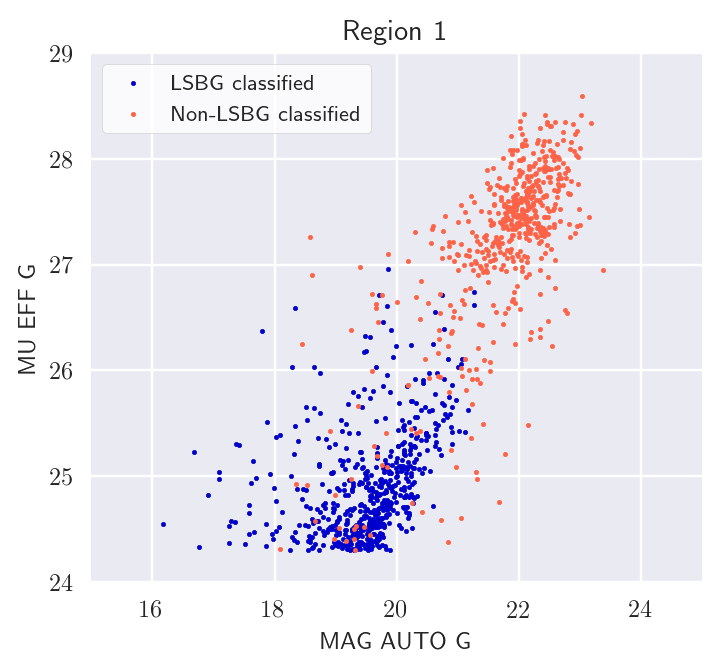

In [25]:
plt.figure(figsize=(4.5, 4.0))

plt.scatter(MAG_G_1[(y_pred_1==1)],MU_EFF_G_1[(y_pred_1==1)], color='mediumblue', s=3.0, label='LSBG classified')
plt.scatter(MAG_G_1[(y_pred_1==0)],MU_EFF_G_1[(y_pred_1==0)], color='tomato', s=3.0, label='Non-LSBG classified')


plt.xlabel('MAG AUTO G', fontsize=10);plt.ylabel('MU EFF G', fontsize=10)
plt.xlim(15,25);plt.ylim(24,29)
plt.legend(frameon=True,loc='upper left', fontsize=9, facecolor='w')
plt.title('Region 1')
plt.show()

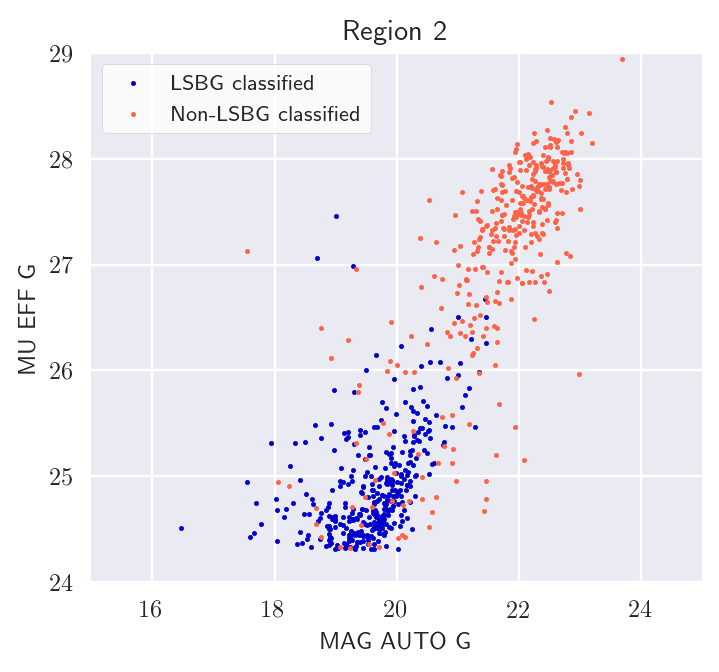

In [26]:
plt.figure(figsize=(4.5, 4.0))

plt.scatter(MAG_G_2[(y_pred_2==1)],MU_EFF_G_2[(y_pred_2==1)], color='mediumblue', s=3.0, label='LSBG classified')
plt.scatter(MAG_G_2[(y_pred_2==0)],MU_EFF_G_2[(y_pred_2==0)], color='tomato', s=3.0, label='Non-LSBG classified')


plt.xlabel('MAG AUTO G', fontsize=10);plt.ylabel('MU EFF G', fontsize=10)
plt.xlim(15,25);plt.ylim(24,29)
plt.legend(frameon=True,loc='upper left', fontsize=9, facecolor='w')
plt.title('Region 2')
plt.show()

Let's make a common plot

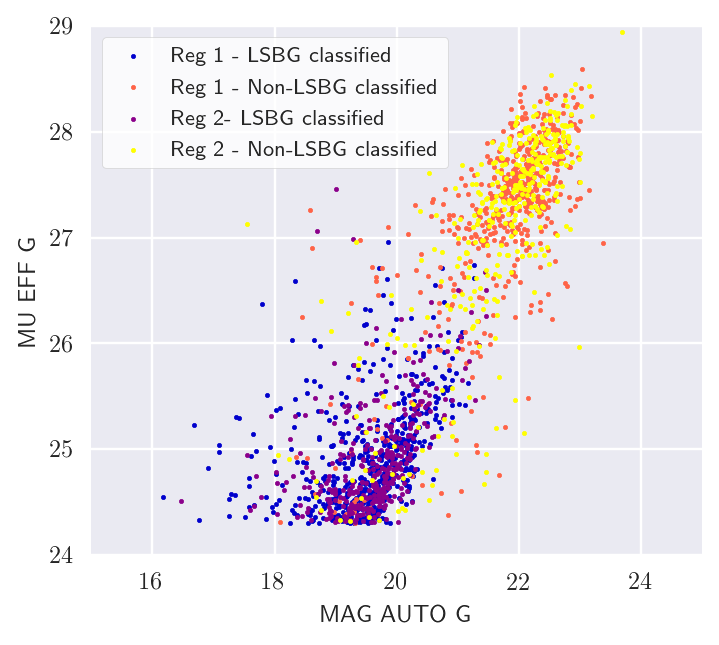

In [27]:
plt.figure(figsize=(4.5, 4.0))

plt.scatter(MAG_G_1[(y_pred_1==1)],MU_EFF_G_1[(y_pred_1==1)], color='mediumblue', s=3.0, label='Reg 1 - LSBG classified')
plt.scatter(MAG_G_1[(y_pred_1==0)],MU_EFF_G_1[(y_pred_1==0)], color='tomato', s=3.0, label='Reg 1 - Non-LSBG classified')
plt.scatter(MAG_G_2[(y_pred_2==1)],MU_EFF_G_2[(y_pred_2==1)], color='darkmagenta', s=3.0, label='Reg 2- LSBG classified')
plt.scatter(MAG_G_2[(y_pred_2==0)],MU_EFF_G_2[(y_pred_2==0)], color='yellow', s=3.0, label='Reg 2 - Non-LSBG classified')

plt.xlabel('MAG AUTO G', fontsize=10);plt.ylabel('MU EFF G', fontsize=10)
plt.xlim(15,25);plt.ylim(24,29)
plt.legend(frameon=True,loc='upper left', fontsize=9, facecolor='w')

plt.show()

#### Distribution in sizes

Here I plot histograms - Distributions in FLUX RADIUS I (arcsec)

In [28]:
RADIUS_I_1 = X_ft_1[:,8]
RADIUS_I_2 = X_ft_2[:,8]

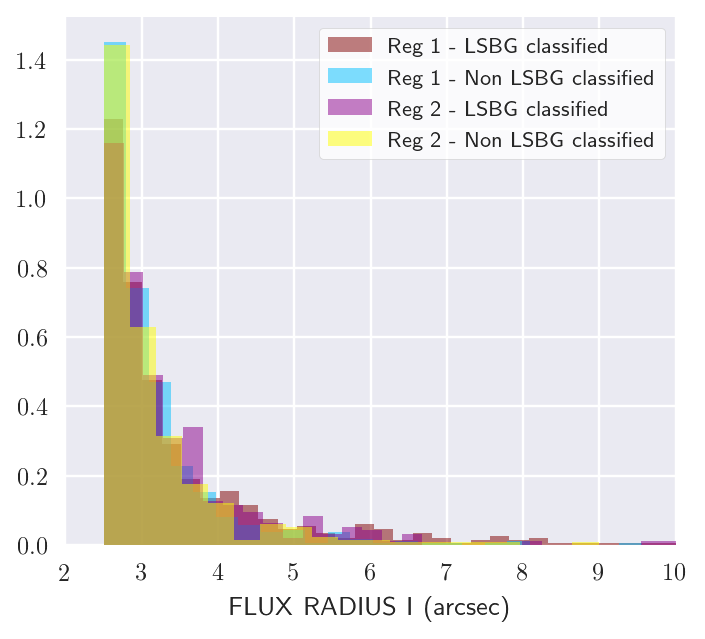

In [29]:
plt.figure(figsize=(4.5, 4.0))

plt.hist(RADIUS_I_1[(y_pred_1==1)], bins=50, density=True, color='maroon', alpha=0.5, label='Reg 1 - LSBG classified')
plt.hist(RADIUS_I_1[(y_pred_1==0)], bins=50, density=True,color='deepskyblue', alpha=0.5, label='Reg 1 - Non LSBG classified')
plt.hist(RADIUS_I_2[(y_pred_2==1)], bins=50, density=True, color='darkmagenta', alpha=0.5, label='Reg 2 - LSBG classified')
plt.hist(RADIUS_I_2[(y_pred_2==0)], bins=50, density=True,color='yellow', alpha=0.5, label='Reg 2 - Non LSBG classified')

plt.xlim(2,10)
plt.xlabel('FLUX RADIUS I (arcsec)')
plt.legend(frameon=True,loc='upper right', fontsize=9, facecolor='w')
plt.show()

As we see, there are not differneces in the distributions between those classified correctly and incorrectly.

Distribution in the sky.

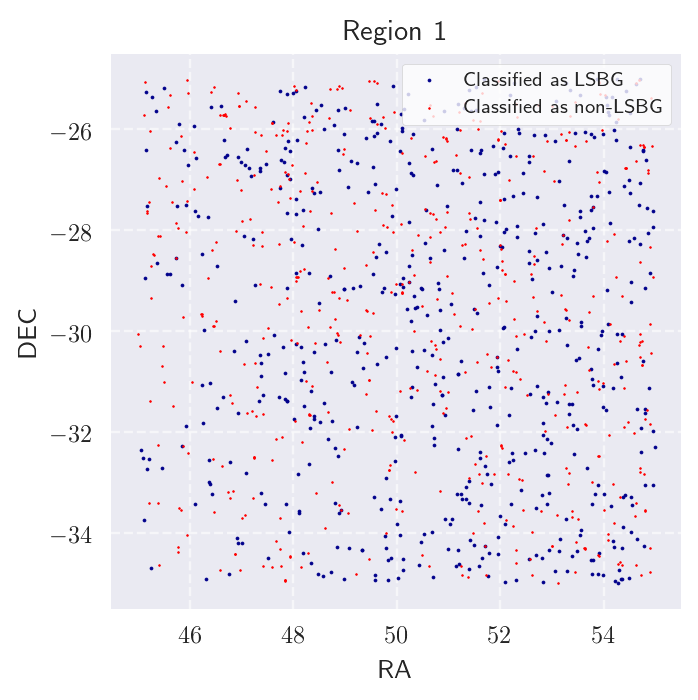

In [30]:
fig = plt.figure(figsize=(4.2,4.2))
plt.scatter(RA_1[(y_pred_1==1)], DEC_1[(y_pred_1==1)], c='darkblue', s=1.5,  label='Classified as LSBG')
plt.scatter(RA_1[(y_pred_1==0)], DEC_1[(y_pred_1==0)], c='red', s=0.5,  label='Classified as non-LSBG')
plt.xlabel('RA'); plt.ylabel('DEC')
plt.grid(ls='--', alpha=0.6)
#plt.xlim(53.5,56.0)
plt.legend(frameon=True, loc='upper right', fontsize=8, facecolor='w')
plt.title('Region 1')
plt.show()

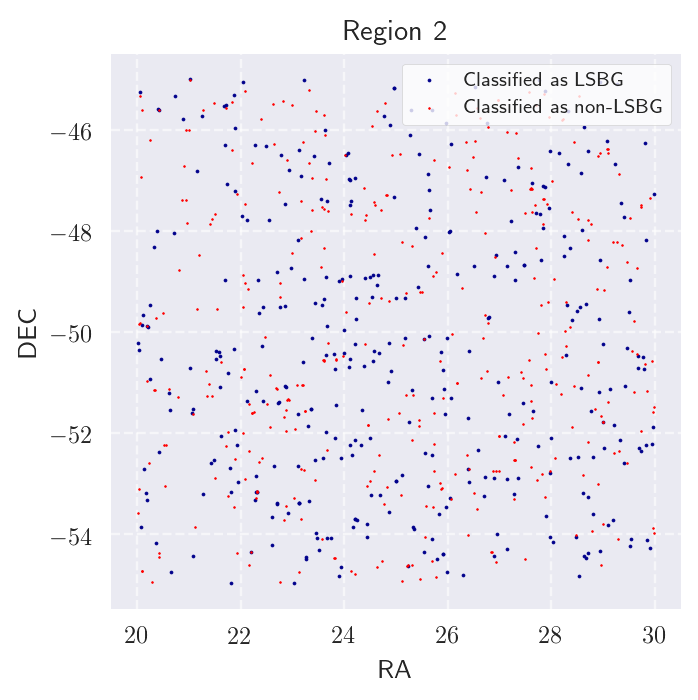

In [31]:
fig = plt.figure(figsize=(4.2,4.2))
plt.scatter(RA_2[(y_pred_2==1)], DEC_2[(y_pred_2==1)], c='darkblue', s=1.5,  label='Classified as LSBG')
plt.scatter(RA_2[(y_pred_2==0)], DEC_2[(y_pred_2==0)], c='red', s=0.5,  label='Classified as non-LSBG')
plt.xlabel('RA'); plt.ylabel('DEC')
plt.grid(ls='--', alpha=0.6)
#plt.xlim(53.5,56.0)
plt.legend(frameon=True, loc='upper right', fontsize=8, facecolor='w')
plt.title('Region 2')
plt.show()

### Color- color diagram

In [36]:
RA_POS = RA_2[(y_pred_2==1)]
DEC_POS =DEC_2[(y_pred_2==1)]
np.savetxt('ForClassification.dat', np.c_[RA_POS, DEC_POS], fmt='%.6f %.6f')